<a href="https://colab.research.google.com/github/fidhaaysha/sarcasm-detection/blob/main/Sarcasm_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U transformers

In [ ]:
# Install Libraries
!pip install -U transformers datasets evaluate pandas scikit-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 440.2 kB/s eta 0:00:00


In [ ]:
# Upload the Kaggle JSON file
from google.colab import files
uploaded = files.upload()  # Upload 'Sarcasm_Headlines_Dataset.json'

Saving Sarcasm_Headlines_Dataset_v2.json to Sarcasm_Headlines_Dataset_v2 (1).json
Saving Sarcasm_Headlines_Dataset.json to Sarcasm_Headlines_Dataset (1).json


In [ ]:
# Load and Preprocess Dataset
import pandas as pd
import json

# Load JSON into DataFrame
data = []
with open("Sarcasm_Headlines_Dataset.json", "r") as f:
    for line in f:
        data.append(json.loads(line))
df = pd.DataFrame(data)

# Keep necessary columns
df = df[["headline", "is_sarcastic"]]
df = df.rename(columns={"headline": "text", "is_sarcastic": "label"})

# Use a subset for fast training
df = df.sample(n=3000, random_state=42).reset_index(drop=True)


In [ ]:
# Train/Validation/Test Split
from sklearn.model_selection import train_test_split

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["text"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42)


In [ ]:
# Tokenize using BERT
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)


In [ ]:
# PyTorch Dataset Class
import torch

class SarcasmDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = SarcasmDataset(train_encodings, train_labels)
val_dataset = SarcasmDataset(val_encodings, val_labels)
test_dataset = SarcasmDataset(test_encodings, test_labels)


/tmp/ipython-input-35-308268771.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", palette="Set2")


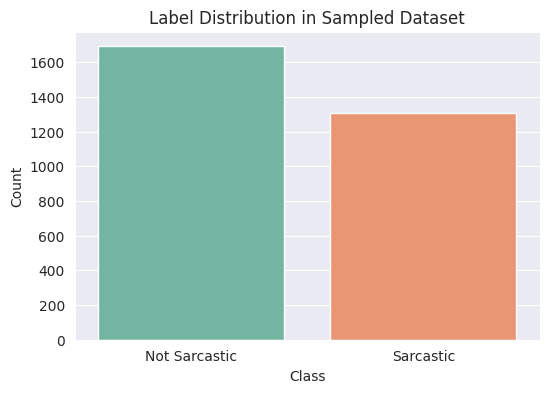

In [ ]:
# EDA – Plot Label Distribution

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="label", palette="Set2")
plt.xticks([0, 1], ["Not Sarcastic", "Sarcastic"])
plt.title("Label Distribution in Sampled Dataset")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [ ]:
# Load BERT Model

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define TrainingArguments

from transformers import TrainingArguments
import os
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir="./sarcasm-results",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,  # For quick training
    logging_dir="./logs"
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# Define Evaluation Metrics

import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

In [ ]:
# Train the Model

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss
500,0.352500


TrainOutput(global_step=600, training_loss=0.32549874623616537, metrics={'train_runtime': 715.8323, 'train_samples_per_second': 6.705, 'train_steps_per_second': 0.838, 'total_flos': 86333315040000.0, 'train_loss': 0.32549874623616537, 'epoch': 2.0})

In [ ]:
# Evaluate on Test Set

results = trainer.evaluate(test_dataset)
print("Test Set Results:", results)

Test Set Results: {'eval_loss': 0.609478235244751, 'eval_accuracy': 0.8566666666666667, 'eval_runtime': 9.1758, 'eval_samples_per_second': 32.695, 'eval_steps_per_second': 4.141, 'epoch': 2.0}


In [ ]:
# Define Prediction Function

def predict(text):
    """
    Predicts sarcasm for input text using the fine-tuned BERT model.
    Returns label (0 = Not Sarcastic, 1 = Sarcastic) and probability.
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1).squeeze()
        label = torch.argmax(probs).item()
        confidence = probs[label].item()
    return label, confidence


In [ ]:
# Interactive UI for Prediction

import ipywidgets as widgets
from IPython.display import display, clear_output

# Function that triggers on button click
def on_button_click(button):
    clear_output(wait=True)
    user_text = text_area.value.strip()
    if not user_text:
        print("⚠️ Please enter some text.")
    else:
        prediction, confidence = predict(user_text)
        label = "Sarcastic" if prediction == 1 else "Not Sarcastic"
        print(f"📝 Prediction: {label} ({confidence * 100:.2f}% confidence)")
    display_ui()

# Function to show widgets again
def display_ui():
    display(text_area, button)

# Text box
text_area = widgets.Textarea(
    value='',
    placeholder='Enter a news headline...',
    description='Headline:',
    layout=widgets.Layout(width='80%', height='80px')
)

# Button
button = widgets.Button(description="Predict Sarcasm")
button.on_click(on_button_click)

# Show the UI
display_ui()


📝 Prediction: Not Sarcastic (99.03% confidence)


Textarea(value='spiderman is real', description='Headline:', layout=Layout(height='80px', width='80%'), placeh…

Button(description='Predict Sarcasm', style=ButtonStyle())

In [ ]:
# Save Model

model.save_pretrained("bert-sarcasm-model")
tokenizer.save_pretrained("bert-sarcasm-model")

('bert-sarcasm-model/tokenizer_config.json',
 'bert-sarcasm-model/special_tokens_map.json',
 'bert-sarcasm-model/vocab.txt',
 'bert-sarcasm-model/added_tokens.json',
 'bert-sarcasm-model/tokenizer.json')